# **Übung 7 (Job Shop Scheduling)**

One common scheduling problem is the job shop, in which multiple jobs are processed on several machines. Each job consists of a sequence of tasks, which must be performed in a given order, and each task must be processed on a specific machine. For example, the job could be the manufacture of a single consumer item, such as an automobile. The problem is to schedule the tasks on the machines so as to minimize the length of the schedule—the time it takes for all the jobs to be completed.

## **1) The Job Shop Problem with Google OR-Tools**



First, we need a mixed-integer formulation of the Job Shop problem.

The following Python solution is directly taken from the Google OR-Tools documentation:

https://developers.google.com/optimization/scheduling/job_shop

*OR-Tools is an open source software suite for optimization, tuned for tackling the world's toughest problems in vehicle routing, flows, integer and linear programming, and constraint programming.*

In [1]:
from __future__ import print_function
import collections
from ortools.sat.python import cp_model # Import Python wrapper for or-tools CP-SAT solver.

def MinimalJobshopSat(jobs):

    """Minimal jobshop problem."""
    # Create the model.
    model = cp_model.CpModel()

    jobs_data = jobs

    machines_count = 1 + max(task[0] for job in jobs_data for task in job)
    all_machines = range(machines_count)

    # Computes horizon dynamically as the sum of all durations.
    horizon = sum(task[1] for job in jobs_data for task in job)

    # Named tuple to store information about created variables.
    task_type = collections.namedtuple('task_type', 'start end interval')
    # Named tuple to manipulate solution information.
    assigned_task_type = collections.namedtuple('assigned_task_type',
                                                'start job index duration')

    # Creates job intervals and add to the corresponding machine lists.
    all_tasks = {}
    machine_to_intervals = collections.defaultdict(list)

    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            duration = task[1]
            suffix = '_%i_%i' % (job_id, task_id)
            start_var = model.NewIntVar(0, horizon, 'start' + suffix)
            end_var = model.NewIntVar(0, horizon, 'end' + suffix)
            interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                                'interval' + suffix)
            all_tasks[job_id, task_id] = task_type(
                start=start_var, end=end_var, interval=interval_var)
            machine_to_intervals[machine].append(interval_var)

    # Create and add disjunctive constraints.
    for machine in all_machines:
        model.AddNoOverlap(machine_to_intervals[machine])

    # Precedences inside a job.
    for job_id, job in enumerate(jobs_data):
        for task_id in range(len(job) - 1):
            model.Add(all_tasks[job_id, task_id +
                                1].start >= all_tasks[job_id, task_id].end)

    # Makespan objective.
    obj_var = model.NewIntVar(0, horizon, 'makespan')
    model.AddMaxEquality(obj_var, [
        all_tasks[job_id, len(job) - 1].end
        for job_id, job in enumerate(jobs_data)
    ])
    model.Minimize(obj_var)

    # Solve model.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL:
        # Create one list of assigned tasks per machine.
        assigned_jobs = collections.defaultdict(list)
        for job_id, job in enumerate(jobs_data):
            for task_id, task in enumerate(job):
                machine = task[0]
                assigned_jobs[machine].append(
                    assigned_task_type(
                        start=solver.Value(all_tasks[job_id, task_id].start),
                        job=job_id,
                        index=task_id,
                        duration=task[1]))

        # Create per machine output lines.
        output = ''
        for machine in all_machines:
            # Sort by starting time.
            assigned_jobs[machine].sort()
            sol_line_tasks = 'Machine ' + str(machine) + ': '
            sol_line = '           '

            for assigned_task in assigned_jobs[machine]:
                name = 'job_%i_%i' % (assigned_task.job, assigned_task.index)
                # Add spaces to output to align columns.
                sol_line_tasks += '%-10s' % name

                start = assigned_task.start
                duration = assigned_task.duration
                sol_tmp = '[%i,%i]' % (start, start + duration)
                # Add spaces to output to align columns.
                sol_line += '%-10s' % sol_tmp

            sol_line += '\n'
            sol_line_tasks += '\n'
            output += sol_line_tasks
            output += sol_line

        # Finally print the solution found.
        print('Optimal Schedule Length: %i' % solver.ObjectiveValue())
        print(output)
        
        print('Status = %s' % solver.StatusName(status))



## **2) Model Results**

### **2a) Google OR-Tools Job Shop Example**

https://developers.google.com/optimization/scheduling/job_shop

**First, we reproduce the example results from the Google OR-Tools guide.**

**Input data:**

In [2]:
jobsA = [[(0, 3), (1, 2), (2, 2)],  # Job0
         [(0, 2), (2, 1), (1, 4)],  # Job1
         [(1, 4), (2, 3)]           # Job2
        ]

# task = (machine_id, processing_time)

**Solve model:**

In [5]:
MinimalJobshopSat(jobsA)

Optimal Schedule Length: 11
Machine 0: job_0_0   job_1_0   
           [0,3]     [3,5]     
Machine 1: job_2_0   job_0_1   job_1_2   
           [0,4]     [4,6]     [7,11]    
Machine 2: job_1_1   job_0_2   job_2_1   
           [5,6]     [6,8]     [8,11]    

Status = OPTIMAL


**The Gantt diagram to this solution:** https://developers.google.com/optimization/scheduling/job_shop#one_solution

### **2b) Produktions- und Logistikmanagement**

#### **Übung 7, Aufgabe 1:**

In [6]:
jobsB = [[(0, 5), (1, 4)],  # A, 0
         [(0, 2), (1, 1)],  # B, 1
         [(1, 3)],          # C, 2         
         [(1, 4), (0, 1)],  # D, 3         
         [(0, 3), (1, 4)],  # E, 4
         [(0, 2), (1, 4)],  # F, 5         
         [(1, 1)],          # G, 6
         [(1, 2)],          # H, 7         
         [(1, 2), (0, 4)],  # I, 8
         [(1, 3), (0, 3)]]  # J, 9

# task = (machine_id, processing_time)

**Solve model:**

In [7]:
MinimalJobshopSat(jobsB)

Optimal Schedule Length: 28
Machine 0: job_0_0   job_1_0   job_4_0   job_5_0   job_3_1   job_8_1   job_9_1   
           [0,5]     [5,7]     [7,10]    [10,12]   [12,13]   [21,25]   [25,28]   
Machine 1: job_2_0   job_6_0   job_3_0   job_1_1   job_7_0   job_4_1   job_5_1   job_8_0   job_9_0   job_0_1   
           [0,3]     [3,4]     [4,8]     [8,9]     [9,11]    [11,15]   [15,19]   [19,21]   [21,24]   [24,28]   

Status = OPTIMAL


**Comparison of mixed-integer formulation and Jackson rule: We obtain the same optimal makespan of 28 time units, but not the same schedule!**

### **2c) Runtime Analysis**

**Finally, we evaluate the time required to solve the job shop problem with a larger number of machines and jobs.**

**First, we define a function that generates a random shop with m Machines and j Jobs:**

In [8]:
import random

def RandomJobShop(NrMachines, NrJobs):
    
    Machines = [m for m in range(0, NrMachines)]
    Jobs = [j for j in range(0, NrJobs)]
    
    JobShop = []
    
    maxTime = 100 # maximum random processing time
    
    for j in Jobs:
        Sequence = random.sample(range(0, NrMachines), NrMachines)
        Times = random.sample(range(0, maxTime), NrMachines)
        Tasks = []        
        for m in Machines:
            Tasks.append((Sequence[m], Times[m]))
            
        JobShop.append(Tasks)
    
    return JobShop

**Example: Random shop with 2 machines and 4 jobs**

In [9]:
print(RandomJobShop(2,4))

[[(1, 67), (0, 20)], [(0, 61), (1, 39)], [(1, 74), (0, 16)], [(1, 57), (0, 11)]]


**And now we check at which number of jobs (with j=m) we hit a maximum acceptable solution time T:**

In [20]:
T = 30 # threshold for solution time, in seconds

import pandas as pd
import time
import io
from contextlib import redirect_stdout

Iterations = pd.DataFrame()
time_solve = 0

k = 1   # iterations, starting with 1
m = 2   # machines, starting with 2 
j = 2   # jobs, starting with 2

trap = io.StringIO()

while time_solve < T:
    
    time_start = time.process_time()
    with redirect_stdout(trap): # suppress text output of function MinimalJobshopSat
        MinimalJobshopSat(RandomJobShop(m,j))
    time_solve = time.process_time()-time_start
    
    Iterations.loc[k, 'm'] = m
    Iterations.loc[k, 'j'] = j
    Iterations.loc[k, 't'] = time_solve
    
    k += 1
    m += 1
    j += 1
    

In [21]:
Iterations.tail()

,m,j,t
9,10.0,10.0,0.906250
10,11.0,11.0,1.718750
11,12.0,12.0,2.750000
12,13.0,13.0,7.203125
13,14.0,14.0,66.468750


Text(0, 0.5, 'Solution time (seconds)')

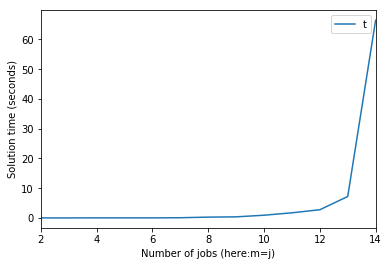

In [22]:
ax = Iterations.plot(x='j', y='t')

ax.set_xlabel("Number of jobs (here:m=j)")
ax.set_ylabel("Solution time (seconds)")